## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
# Add functions path
sys.path.append('../Functions')

## Load Dataset

In [67]:
from datasets import load_stratified_dataset
df = load_stratified_dataset(path='../Datasets/full_good_bad_dataset.csv', labels='label', samples_per_label=2800)

### Dataframe for results
Create a dataframe, that contains all model results!

In [68]:
model_results = pd.DataFrame({'Preprocessing': ['Word Bagging', 'Word Embedding']})

## Prepare Dataset

In [69]:
df.label.value_counts()

1    2800
0    2800
Name: label, dtype: int64

In [70]:
df.text.isnull().sum()

0

In [71]:
# TfidfVectorizer generates bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

# sublinear_tf: use logarithmic form for frequency
# min_df: minimum numbers of documents a word must be present to keep it
# ngram_range: number of ngrams to use
# stopwords: remove all common pronouns in given language

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.text).toarray()

labels = df.label

print('{} samples represented by {} features'.format(features.shape[0], features.shape[1]))

5600 samples represented by 37934 features


In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state = 42)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [73]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)
result = clf.score(X_test_tfidf, y_test)
model_results['NB'] = [result.round(3), None]
print(f"Accuracy for test set : {clf.score(X_test_tfidf, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {clf.score(X_train_tfidf, y_train) * 100:.3f}%", )

Accuracy for test set : 83.143%
Accuracy for train set: 90.238%


In [74]:
from sklearn.svm import SVC

svc = SVC().fit(X_train_tfidf, y_train)
result = svc.score(X_test_tfidf, y_test)
model_results['SVC'] = [result, None]
print(f"Accuracy for test set : {svc.score(X_test_tfidf, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {svc.score(X_train_tfidf, y_train) * 100:.3f}%", )

Accuracy for test set : 86.500%
Accuracy for train set: 99.190%


In [75]:
from xgboost import XGBClassifier

xgb = XGBClassifier().fit(X_train_tfidf, y_train)
result = xgb.score(X_test_tfidf, y_test)
model_results['XGB'] = [result, None]
print(f"Accuracy for test set : {xgb.score(X_test_tfidf, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {xgb.score(X_train_tfidf, y_train) * 100:.3f}%", )

Accuracy for test set : 81.429%
Accuracy for train set: 88.690%


In [76]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(X_train_tfidf, y_train)
result = svc.score(X_test_tfidf, y_test)
model_results['SVCLinear'] = [result, None]
print(f"Accuracy for test set : {svc.score(X_test_tfidf, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {svc.score(X_train_tfidf, y_train) * 100:.3f}%", )

Accuracy for test set : 87.357%
Accuracy for train set: 99.690%


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

lr = LogisticRegression(C=0.8)
#poly = PolynomialFeatures(1)
#X_train_poly = poly.fit_transform(X_train_tfidf)
#X_test_poly = poly.transform(X_test_tfidf)
X_train_poly = X_train_tfidf
X_test_poly = X_test_tfidf
lr.fit(X_train_poly, y_train)
result = lr.score(X_test_tfidf, y_test)
model_results['LogisticRegr'] = [result, None]
print(f"Accuracy for test set : {lr.score(X_test_poly, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {lr.score(X_train_poly, y_train) * 100:.3f}%", )

Accuracy for test set : 83.200%
Accuracy for train set: 94.733%


## Word Embeddings

In [32]:
import spacy
from time import time

## Word Embeddings (Word Vectors)

In [34]:
# Load loarge model
nlp = spacy.load('en_core_web_sm')

# Disabling other pipes, no need for them, takes too much time
with nlp.disable_pipes():
    vectors = np.array([nlp(text).vector for text in df.text])

In [35]:
vectors.shape

(2000, 96)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(vectors, df['label'], random_state = 42)

In [38]:
svc = SVC().fit(X_train, y_train)
result = svc.score(X_test, y_test)
model_results.loc[1, 'SVC'] = result
print(f"Accuracy for test set : {svc.score(X_test, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {svc.score(X_train, y_train) * 100:.3f}%", )

Accuracy for test set : 68.400%
Accuracy for train set: 74.800%


In [39]:
xgb = XGBClassifier().fit(X_train, y_train)
result = xgb.score(X_test, y_test)
model_results.loc[1, 'XGB'] = result
print(f"Accuracy for test set : {xgb.score(X_test, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {xgb.score(X_train, y_train) * 100:.3f}%", )

Accuracy for test set : 69.600%
Accuracy for train set: 93.267%


In [40]:
svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(X_train, y_train)
result = svc.score(X_test, y_test)
model_results.loc[1, 'SVCLinear'] = result
print(f"Accuracy for test set : {svc.score(X_test, y_test) * 100:.3f}%", )
print(f"Accuracy for train set: {svc.score(X_train, y_train) * 100:.3f}%", )

Accuracy for test set : 70.200%
Accuracy for train set: 75.867%


In [77]:
model_results.round(3)

,Preprocessing,NB,SVC,XGB,SVCLinear
0,Word Bagging,0.831,0.865,0.814,0.874
1,Word Embedding,NaN,NaN,NaN,NaN


### SVC different categories

In [20]:
# Load training set
df = load_stratified_dataset(path='../Datasets/dataset_categories/dataset.csv', labels='category', samples_per_label=800)
# Shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)
mid = int(df.shape[0]/2)
X_train, y_train = df[:mid].text, df[:mid].category

# Load test set for every category
df = df[mid:]
test_set = {}
for i in df.category.unique():
    test_set[i] = df[df['category'] == i].text.values

In [21]:
# Fit model
svc = SVC()
X_train_tfidf = tfidf.fit_transform(X_train)
svc.fit(X_train_tfidf, y_train)

predictions = []
# Get accuracies for categories
for key, value in test_set.items():
    X_test_tfidf = tfidf.transform(value)
    y_test = np.full(value.shape[0], key)
    print('Score for category {: <13}:   {:.1f} %'.format(key, svc.score(X_test_tfidf, y_test)*100))
    # Get Predictions
    cat, val = np.unique(svc.predict(X_test_tfidf), return_counts=True)
    #pred = sorted(list(zip(cat, (val/y_test.shape[0]*100).round(1))) , key=lambda x: x[1], reverse=True)
    predictions.append((cat, (val/y_test.shape[0]*100).round(1)))

Score for category politics_big :   64.3 %
Score for category world_big    :   67.6 %
Score for category financial_big:   68.9 %
Score for category sports_big   :   72.9 %
Score for category entertainment_big:   73.1 %
Score for category technology_big:   77.3 %
Score for category travel_big   :   67.9 %


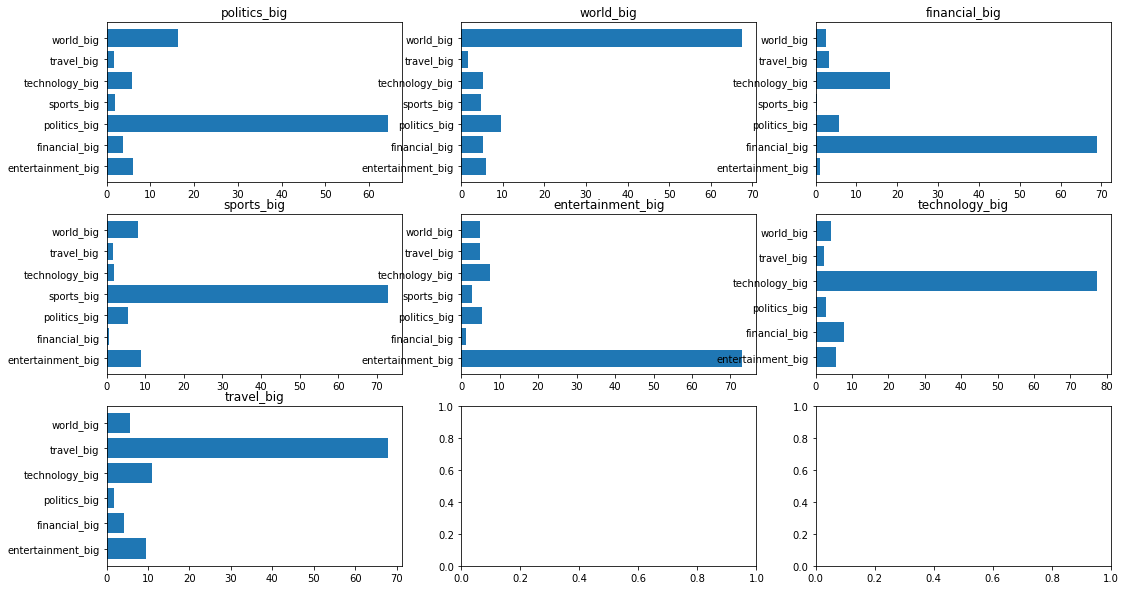

In [22]:
fig, ax = plt.subplots(3,3,figsize=(18,10))
simple_h_bar(predictions[0][0], predictions[0][1], ax=ax[0][0], title=predictions[0][0][np.argmax(predictions[0][1])])
simple_h_bar(predictions[1][0], predictions[1][1], ax=ax[0][1], title=predictions[1][0][np.argmax(predictions[1][1])])
simple_h_bar(predictions[2][0], predictions[2][1], ax=ax[0][2], title=predictions[2][0][np.argmax(predictions[2][1])])
simple_h_bar(predictions[3][0], predictions[3][1], ax=ax[1][0], title=predictions[3][0][np.argmax(predictions[3][1])])
simple_h_bar(predictions[4][0], predictions[4][1], ax=ax[1][1], title=predictions[4][0][np.argmax(predictions[4][1])])
simple_h_bar(predictions[5][0], predictions[5][1], ax=ax[1][2], title=predictions[5][0][np.argmax(predictions[5][1])])
simple_h_bar(predictions[6][0], predictions[6][1], ax=ax[2][0], title=predictions[6][0][np.argmax(predictions[6][1])])

### Accuracy in dependence of training size

In [42]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english')

svc = SVC()

# Load loarge model
nlp = spacy.load('en_core_web_sm')

samples = []
word_bagging = []
word_embedding = []
for num_samples in [10, 100, 300, 450]:
    start_time = time()
    
    samples.append(num_samples)
    
    df = load_stratified_dataset(path='../Datasets/full_good_bad_dataset.csv', labels='label', samples_per_label=num_samples)

    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state = 42)

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    svc.fit(X_train_tfidf, y_train)
    result = svc.score(X_test_tfidf, y_test)
    word_bagging.append(result)

    # Disabling other pipes, no need for them, takes too much time
    with nlp.disable_pipes():
        vectors = np.array([nlp(text).vector for text in df.text])

    X_train, X_test, y_train, y_test = train_test_split(vectors, df['label'], random_state = 42)

    svc.fit(X_train, y_train)
    result = svc.score(X_test, y_test)
    word_embedding.append(result)
    
    print('Calculation with {} samples finished in {:.1f}s'.format(num_samples, time()-start_time))

Calculation with 10 samples finished in 4.3s
Calculation with 100 samples finished in 22.4s
Calculation with 300 samples finished in 65.3s
Calculation with 450 samples finished in 97.4s


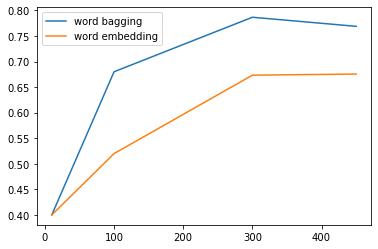

In [43]:
plt.plot(samples, word_bagging, label='word bagging')
plt.plot(samples, word_embedding, label='word embedding')
plt.legend();

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state = 42)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [45]:
svc = SVC(C=0.8)
svc.fit(X_train_tfidf, y_train)
svc.score(X_test_tfidf, y_test), svc.score(X_train_tfidf, y_train)


(0.76, 0.9955555555555555)

In [46]:
test = []
train = []
c_val = []
for c in np.logspace(-1,1,10):
    svc = SVC(C=c, kernel='linear')
    svc.fit(X_train_tfidf, y_train)
    test_, train_ = svc.score(X_test_tfidf, y_test), svc.score(X_train_tfidf, y_train)
    test.append(test_)
    train.append(train_)
    c_val.append(c)

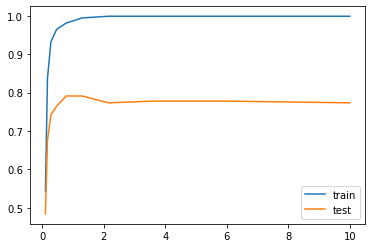

In [47]:
plt.plot(c_val, train, label='train')
plt.plot(c_val, test, label='test')
plt.legend();

In [48]:
test = []
train = []
c_val = []
for c in np.logspace(-1,1,10):
    lr = LogisticRegression(C=c, max_iter=100000)
    lr.fit(X_train_tfidf, y_train)
    test_, train_ = lr.score(X_test_tfidf, y_test), lr.score(X_train_tfidf, y_train)
    test.append(test_)
    train.append(train_)
    c_val.append(c)

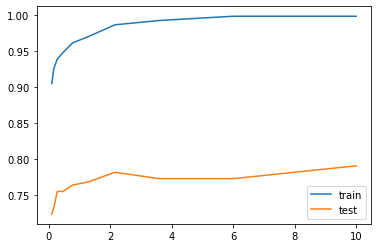

In [49]:
plt.plot(c_val, train, label='train')
plt.plot(c_val, test, label='test')
plt.legend();